In [1]:
# import requests
import torch
# import os
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
file = "nomes_br.csv"
words = []
with open(file, 'r', encoding='utf-8') as f:
    words = f.read().lower().splitlines()

file = "names.txt"
with open(file, 'r', encoding='utf-8') as f:
    for w in f.read().lower().splitlines():
        words.append(w) 
words = list(dict.fromkeys(words))
len(words), words[:10]

(57750,
 ['adao',
  'adelina',
  'adelson',
  'ademar',
  'ademir',
  'adenilson',
  'adilson',
  'adriana',
  'adriano',
  'adriele'])

In [3]:
#build the vocabulary os chars and mapping to/from integers
chars = ['.']+sorted(list(set(''.join(words))))
ctoi = {c:i for i,c in enumerate(chars)}
itoc = {i:c for c,i in ctoi.items()}
vocab_size = len(itoc)
print(itoc)
print(vocab_size)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
27


In [4]:
# build the dataset

block_size = 4
def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = ctoi[ch]
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# training split, dev/validation split, test split
# 80%, 10% , 10%
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([348607, 4]) torch.Size([348607])
torch.Size([43537, 4]) torch.Size([43537])
torch.Size([43738, 4]) torch.Size([43738])


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb),                generator=g)

W1 = torch.randn((n_emb * block_size, n_hidden),    generator=g) * ((5/3) / ((n_emb*block_size) ** 0.5))
# b1 = torch.randn(n_hidden,                          generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
b2 = torch.randn(vocab_size,                        generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden)) 
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden)) 

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

14097


In [7]:
max_steps = 200000
batch_size = 32
lossi = []

def feedfoward(Xf, calcBn = False):
    global bnmean_running, bnstd_running
    # foward pass
    emb = C[Xf] # [32, 3, 2]
    emb_cat = emb.view(emb.shape[0], -1)

    hpreact = emb_cat @ W1 #+ b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - (bnmeani if calcBn else bnmean_running)) / (bnstdi if calcBn else bnstd_running)  + bnbias
    
    if calcBn:
        with torch.no_grad():
            bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani 
            bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi 
    
    h = torch.tanh(hpreact) # (32, 100)
    logits = h @ W2 + b2
    return logits

In [8]:
for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    logits = feedfoward(Xb, True)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < max_steps/2 else (0.01 if i < max_steps * 0.75 else 0.005) # lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

print(loss.item())

      0/ 200000: 3.3073
  10000/ 200000: 2.1901
  20000/ 200000: 2.2002
  30000/ 200000: 2.2775
  40000/ 200000: 2.1877
  50000/ 200000: 1.7750
  60000/ 200000: 2.0115
  70000/ 200000: 2.1200
  80000/ 200000: 1.7939
  90000/ 200000: 1.8951
 100000/ 200000: 2.1882
 110000/ 200000: 2.1638
 120000/ 200000: 2.2586
 130000/ 200000: 2.2614
 140000/ 200000: 2.0924
 150000/ 200000: 1.9300
 160000/ 200000: 2.7094
 170000/ 200000: 1.7180
 180000/ 200000: 1.9944
 190000/ 200000: 2.5841
2.3070268630981445


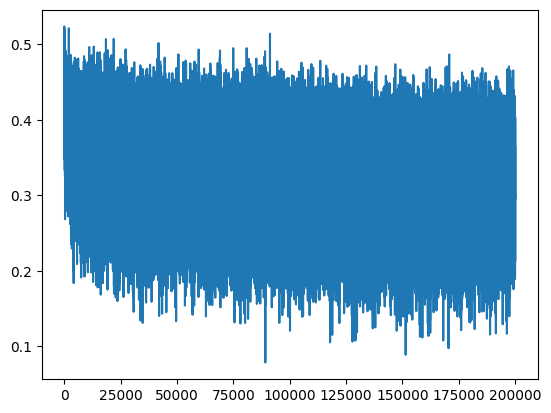

In [9]:
plt.plot(lossi)

In [10]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    # emb = C[x] # [32, 3, 2]
    # embcat = emb.view(emb.shape[0], -1)
    # hpreact = embcat @ W1 #+ b1
    # # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    # hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    # h = torch.tanh(hpreact) # (32, 100)
    # logits = h @ W2 + b2
    logits = feedfoward(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.01943039894104
val 2.0467283725738525


In [ ]:
# plt.figure(figsize=(8,8))
# plt.scatter(C[:,0].data, C[:,1].data, s=200)
# for i in range(C.shape[0]):
#     plt.text(C[i,0].item(), C[i,1].item(), itoc[i], ha="center", va="center", color="white")
# plt.grid("minor")

In [11]:
# sample from model
g1 = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        # emb = C[torch.tensor([context])]
        # embcat = emb.view(emb.shape[0], -1)
        # hpreact = embcat @ W1 #+ b1
        # # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
        # hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        # h = torch.tanh(hpreact) # (32, 100)
        # logits = h @ W2 + b2
        logits = feedfoward(torch.tensor([context]))

        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g1).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itoc[i] for i in out))

eria.
gryanna.
elved.
ryam.
renardiene.
leonize.
edieli.
jemiloelle.
elivania.
raylyn.
markel.
noshiberg.
hiriel.
jocir.
jenildete.
casumarice.
ruylynn.
eliyama.
maston.
mahil.


C:\Users\Leonardo.santos\AppData\Local\Temp\ipykernel_17448\2265824741.py:13: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  bnstdi = hpreact.std(0, keepdim=True)
